In [2]:
##Lib importing
##import torch
import numpy as np
import time
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models, datasets
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
from PIL import Image, ImageOps
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score,precision_score, recall_score , multilabel_confusion_matrix,classification_report
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

## using new data set

new_path_train='/content/drive/MyDrive/DataSets/Aug_Data/train'
new_path_test='/content/drive/MyDrive/DataSets/Aug_Data/test'

In [7]:
## Data loader
transform=transforms.ToTensor()
df_X=datasets.ImageFolder(root=new_path_train, transform=transform)
validation_per=int(len(df_X) * 0.35)
train_per=len(df_X)-validation_per
train_data, val_data =random_split(df_X, [train_per, validation_per])
train_loader=DataLoader(train_data, batch_size=16, shuffle=True)
val_loader=DataLoader(val_data, batch_size=16, shuffle=False)

In [ ]:
##model

class convolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    ##1
    
    self.conv1=nn.Conv2d(3,64,3,1,1)
    self.Batch1=nn.BatchNorm2d(64)
    self.drop1= nn.Dropout(0.2)

    ##2
    self.conv2=nn.Conv2d(64,64,3,1,1)
    self.Batch2=nn.BatchNorm2d(64)
    self.drop2= nn.Dropout(0.2)
    ##3
    self.conv3=nn.Conv2d(64,128,3,1,1)
    self.Batch3=nn.BatchNorm2d(128)
    self.drop3= nn.Dropout(0.2)
    ##4
    self.conv4=nn.Conv2d(128,128,3,1,1)
    self.Batch4=nn.BatchNorm2d(128)
    self.drop4= nn.Dropout(0.2)
    ##5
    self.conv5=nn.Conv2d(128,256,3,1,1)
    self.Batch5=nn.BatchNorm2d(256)
    self.drop5= nn.Dropout(0.2)
    ##6
    self.conv6=nn.Conv2d(256,256,3,1,1)
    self.Batch6=nn.BatchNorm2d(256)
    self.drop6= nn.Dropout(0.2)

    self.flatten=nn.Flatten()
    ##fully connected

    self.fc1=nn.Linear(256*2*2,512)
    self.Batchfc1=nn.BatchNorm1d(512)
    self.fc2=nn.Linear(512,256)
    self.Batchfc2=nn.BatchNorm1d(256)
    self.fc3=nn.Linear(256,3)

  def forward(self, X):
    ##1 CN
    X=self.conv1(X)
    X=F.max_pool2d(X,2)
    X=F.relu(self.Batch1(X))

    X=self.drop1(X)


    ##2
    X=self.conv2(X)
    X=F.max_pool2d(X,2)
    X=F.relu(self.Batch2(X))

    X=self.drop2(X)


    #3
    X=self.conv3(X)
    X=F.max_pool2d(X,2)
    X=F.relu(self.Batch3(X))
    X=self.drop3(X)

    #4
    X=self.conv4(X)
    X=F.max_pool2d(X,2)
    X=F.relu(self.Batch4(X))
    X=self.drop4(X)

    #5
    X=self.conv5(X)
    X=F.max_pool2d(X,2)
    X=F.relu(self.Batch5(X))
    X=self.drop5(X)

    #6
    X=self.conv6(X)
    X=F.max_pool2d(X,2,2)
    X=F.relu(self.Batch6(X))
    X=self.drop6(X)

    ##Fc
    X=self.flatten(X)
    # fully connected layers
    X=F.relu(self.Batchfc1(self.fc1(X)))
    X=F.relu(self.Batchfc2(self.fc2(X)))
    X=self.fc3(X)



    return X

In [11]:
from torchsummary import summary
torch.manual_seed(42)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=convolutionalNetwork().to(device)
summary(model, input_size=(3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
       BatchNorm2d-2           [-1, 64, 75, 75]             128
           Dropout-3           [-1, 64, 75, 75]               0
            Conv2d-4           [-1, 64, 75, 75]          36,928
       BatchNorm2d-5           [-1, 64, 37, 37]             128
           Dropout-6           [-1, 64, 37, 37]               0
            Conv2d-7          [-1, 128, 37, 37]          73,856
       BatchNorm2d-8          [-1, 128, 18, 18]             256
           Dropout-9          [-1, 128, 18, 18]               0
           Conv2d-10          [-1, 128, 18, 18]         147,584
      BatchNorm2d-11            [-1, 128, 9, 9]             256
          Dropout-12            [-1, 128, 9, 9]               0
           Conv2d-13            [-1, 256, 9, 9]         295,168
      BatchNorm2d-14            [-1, 25

In [8]:
#loss function
criterion=nn.CrossEntropyLoss()

In [12]:
## lr
from torch.optim.lr_scheduler import LinearLR
optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
scheduler=torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=10)

In [13]:
##calculating f1,recall,..

def Show_Result_parameters(y_dataset, y_prediction):

    acc=accuracy_score(y_dataset,y_prediction)
    print(f'Accuracy Score:{acc:.4f}')
    f1=f1_score(y_dataset,y_prediction, average='macro', zero_division=0)
    print(f'F1 Score:{f1:.4f}')
    precision=precision_score(y_dataset, y_prediction, average='macro', zero_division=0)
    print(f'Precision Score:{precision:.4f}')
    recall=recall_score(y_dataset,y_prediction, average='macro', zero_division=0)
    print(f'Recall Score:{recall:.4f}')

In [ ]:

ENumbers=25
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]

for epoch in range(ENumbers):
    start_time=time.time()
    model.train()
    running_train_loss=0.0
    trn_correct=0
    trn_total=0

    for tr_images, tclasss in train_loader:
        tr_images, tclasss = tr_images.to(device), tclasss.to(device)

        outputs=model(tr_images)
        loss=criterion(outputs, tclasss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        predicts=torch.argmax(outputs, dim=1)
        trn_correct+=(predicts == tclasss).sum().item()
        trn_total+=tclasss.size(0)

    avg_train_loss=running_train_loss/len(train_loader)
    train_accuracy=trn_correct/trn_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    #val data set
    model.eval()
    running_val_loss=0.0
    val_correct=0
    val_total=0
    y_predict=[]
    y_val=[]

    with torch.no_grad():
        for Val_images, classs in val_loader:
            Val_images, classs = Val_images.to(device), classs.to(device)
            outputs = model(Val_images)
            loss = criterion(outputs, classs)
            running_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_correct+=(preds == classs).sum().item()
            val_total+=classs.size(0)

            y_predict.extend(preds.cpu().numpy())
            y_val.extend(classs.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    current_time=time.time()
    total_time=current_time-start_time
    print(f'Epoch =[{epoch+1} in {ENumbers}] Training takes {total_time/60} minutes')
    print(f'learning rate {scheduler.get_last_lr()[0]:.6f}')
    print(f'Training Loss: {avg_train_loss:.4f} & Training Acc: {train_accuracy:.4f} ** Validation Loss: {avg_val_loss:.4f} & Validation Acc: {val_accuracy:.4f}')
    print('parameters:')
    Show_Result_parameters(y_val,y_predict)
    print('------------------------------------------------------------')

Epoch =[1 in 25] Training takes 33.13373710711797 minutes
learning rate 0.001900
Training Loss: 0.4602 & Training Acc: 0.8139 ** Validation Loss: 0.3150 & Validation Acc: 0.8793
parameters:
Accuracy Score:0.8793
F1 Score:0.8755
Precision Score:0.8824
Recall Score:0.8780
------------------------------------------------------------
Epoch =[2 in 25] Training takes 7.164387826124827 minutes
learning rate 0.002800
Training Loss: 0.3329 & Training Acc: 0.8810 ** Validation Loss: 0.2776 & Validation Acc: 0.8866
parameters:
Accuracy Score:0.8866
F1 Score:0.8860
Precision Score:0.8950
Recall Score:0.8850
------------------------------------------------------------
Epoch =[3 in 25] Training takes 6.773138578732809 minutes
learning rate 0.003700
Training Loss: 0.3018 & Training Acc: 0.8983 ** Validation Loss: 0.3784 & Validation Acc: 0.8405
parameters:
Accuracy Score:0.8405
F1 Score:0.8315
Precision Score:0.8591
Recall Score:0.8381
------------------------------------------------------------
Epoc

In [15]:
##saving the plotting variables
np.save("y_predict.npy", y_predict)
np.save("y_val.npy", y_val)
np.save('/content/drive/MyDrive/Hw2/better/y_predict.npy', y_predict)
np.save('/content/drive/MyDrive/Hw2/better/y_val.npy', y_val)
torch.save(model.state_dict(),'better_Xray_CNN_HW2.pt')
torch.save(model.state_dict(), "/content/drive/MyDrive/Hw2/better/better_Xray_CNN_HW2.pth")

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


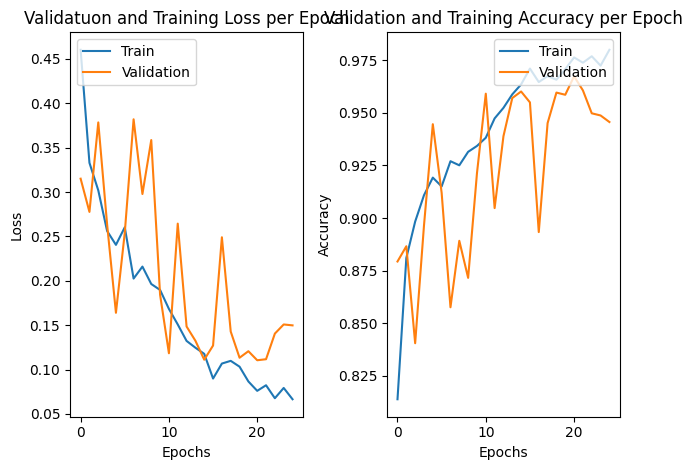

              precision    recall  f1-score   support

     COVID19       0.98      0.95      0.96       639
      NORMAL       0.97      0.92      0.95       664
   PNEUMONIA       0.89      0.97      0.93       628

    accuracy                           0.95      1931
   macro avg       0.95      0.95      0.95      1931
weighted avg       0.95      0.95      0.95      1931



In [16]:
labels=df_X.classes
print(df_X.class_to_idx)
plt.figure()

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validatuon and Training Loss per Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy per Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

print((classification_report(y_val,y_predict, target_names=labels)))

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


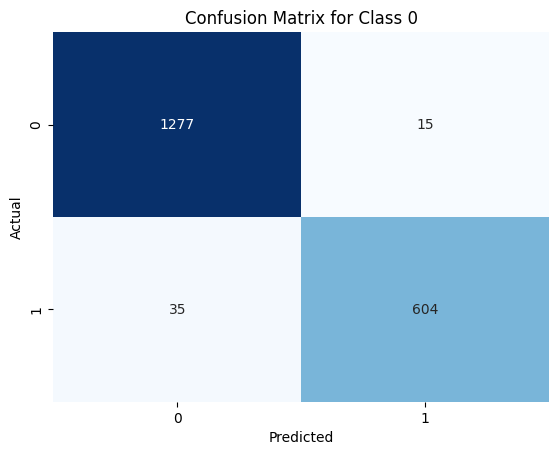

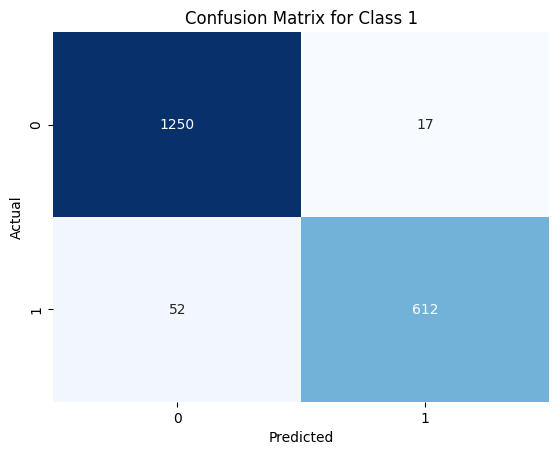

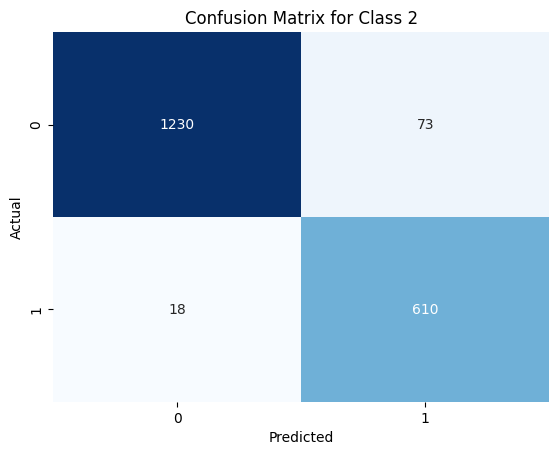

In [17]:
ml_cm_1= multilabel_confusion_matrix(y_val,y_predict)
print(df_X.class_to_idx)
for i, cm in enumerate(ml_cm_1):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [19]:
##testing
testing_model=convolutionalNetwork()
testing_model.load_state_dict(torch.load('better_Xray_CNN_HW2.pt'))
testing_model.to(device)
testing_model.eval()

convolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop4): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Batch5): BatchNorm2d(256, eps=1e-05, momentum=0.1, a

In [20]:
## Data loader
transform=transforms.ToTensor()
dfT_X=datasets.ImageFolder(root=new_path_test, transform=transform)
test_loader=DataLoader(dfT_X, batch_size=16, shuffle=False)
Test_labelclass=dfT_X.classes

In [ ]:
#using model
test_predict=[]
test_y=[]

with torch.no_grad():
    for test_X, test_class in test_loader:
        test_X=test_X.to(device)
        test_class = test_class.to(device)

        outputs=testing_model(test_X)
        preds=torch.argmax(outputs, dim=1)  

        test_predict.extend(preds.cpu().numpy())
        test_y.extend(test_class.cpu().numpy())



In [22]:
np.save('/content/drive/MyDrive/Hw2/better/y_test.npy', np.array(test_y))
np.save('/content/drive/MyDrive/Hw2/better/y_test_preds.npy', np.array(test_predict))

In [23]:
print(classification_report(test_y, test_predict, target_names=Test_labelclass))


              precision    recall  f1-score   support

     COVID19       0.98      0.95      0.97       464
      NORMAL       0.94      0.89      0.91       464
   PNEUMONIA       0.87      0.95      0.91       464

    accuracy                           0.93      1392
   macro avg       0.93      0.93      0.93      1392
weighted avg       0.93      0.93      0.93      1392



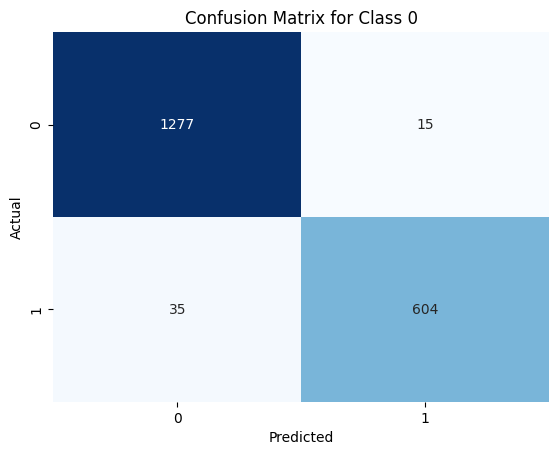

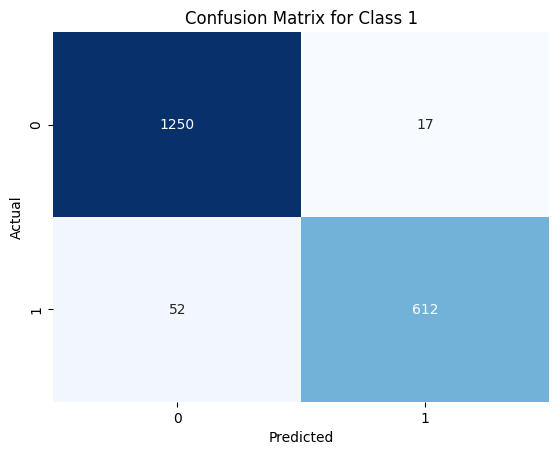

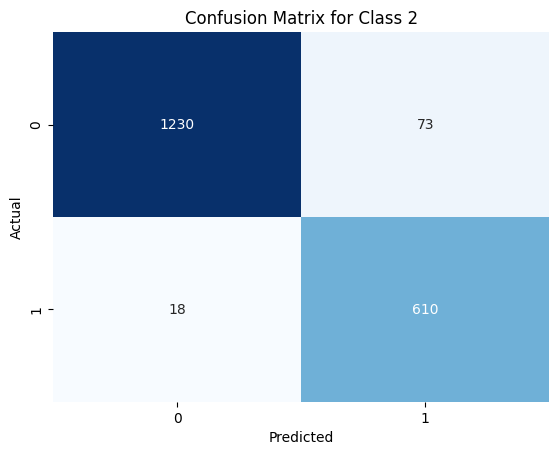

In [ ]:
ml_cm_2= multilabel_confusion_matrix(test_y,test_predict)

for i, cm in enumerate(ml_cm_2):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()